In [1]:
import librosa
import numpy as np
audio_data = 'trial2.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))#<class 'numpy.ndarray'> <class 'int'>print(x.shape, sr)#(94316,) 22050


<class 'numpy.ndarray'> <class 'int'>


In [2]:
import IPython.display as ipd
ipd.Audio(audio_data)

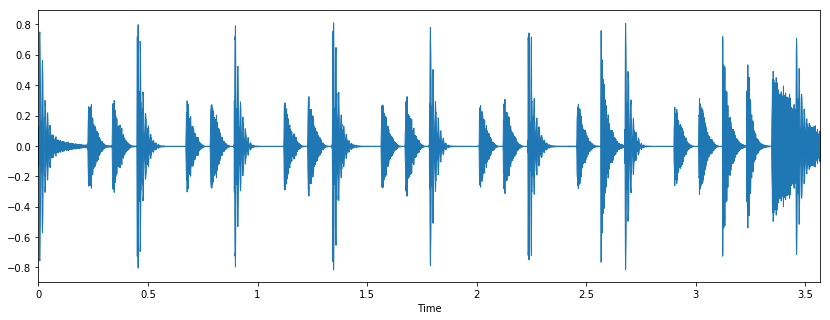

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)


(12, 154)


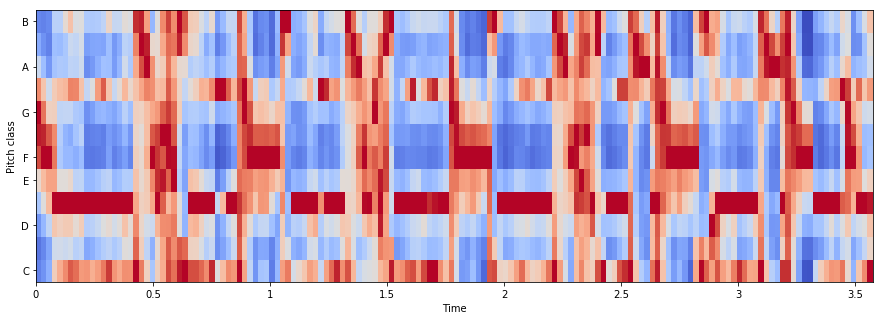

In [4]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
print(chromagram.shape)

In [5]:
#N , M and tao set according to convenience
M = 25 # to get time delay embedding
N = chromagram.shape[1]-M #for nth time-delay embedding
tao = 1
V = np.zeros((N,12*M)) #initialize array of time delay embedding
dummy = np.zeros((12*M))

In [6]:
for n in range(N):
    for i in range (12*M):
        dummy[i] = chromagram[i//M][n + i%M]
    V[n] = dummy
    
#V[n] is the required nth time-delay embedding

In [7]:
#normalize the time_delay_embedding
from sklearn.preprocessing import normalize

time_delay_embedding = normalize(V , axis=1 , norm='l1')

In [8]:
#Calculate difference of arrays arr1 and arr2
def diff_arr(arr1,arr2):
    arr3 = np.zeros((arr1.size))
    for i in range(arr1.size):
        arr3[i] = arr1[i] - arr2[i]
    return arr3

In [9]:
from numpy import linalg as LA
#get the self semiliarity matrix
S = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        S[i][j] = 0.5*(LA.norm(diff_arr(time_delay_embedding[i],time_delay_embedding[j])))
print(S)

[[0.         0.00735319 0.01118232 ... 0.02109128 0.02063185 0.02046601]
 [0.00735319 0.         0.00788097 ... 0.02097437 0.02042309 0.02008749]
 [0.01118232 0.00788097 0.         ... 0.02145014 0.0207394  0.01996816]
 ...
 [0.02109128 0.02097437 0.02145014 ... 0.         0.01209495 0.01860562]
 [0.02063185 0.02042309 0.0207394  ... 0.01209495 0.         0.01222792]
 [0.02046601 0.02008749 0.01996816 ... 0.01860562 0.01222792 0.        ]]


In [10]:
# Heavside step function
def H(h):
    if(h >= 0):
        return 1
    else:
        return 0

In [11]:
#nearest neihbour thresholding to get Ri,j

theta = 50
s = np.zeros((N))
epsilon = np.zeros((N))
R = np.zeros((N,N))

for n in range(N):
    s = S[:,n] # nth column of S
    np.sort(s)
    epsilon[n] = s[theta] # nth threshold for theta-nearest neighbour
    
for i in range(N):
    for j in range(N):
        if(((epsilon[i] - S[i][j]) >= 0) or ((epsilon[j] - S[i][j]) >= 0)):
            R[i][j] = 1
        else:
            R[i][j] = 0
print(R)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]]


In [12]:
# calculation of Weight matrix Wi,j

W = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        W[i][j] = (R[i][j])*(1 - S[i][j])
print(W)

[[1.         0.99264681 0.98881768 ... 0.         0.         0.        ]
 [0.99264681 1.         0.99211903 ... 0.         0.         0.97991251]
 [0.98881768 0.99211903 1.         ... 0.         0.         0.98003184]
 ...
 [0.         0.         0.         ... 1.         0.98790505 0.        ]
 [0.         0.         0.         ... 0.98790505 1.         0.98777208]
 [0.         0.97991251 0.98003184 ... 0.         0.98777208 1.        ]]


In [13]:
chromagram2 = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)

In [14]:
N_prime = chromagram.shape[1]-M
print(chromagram.shape[0])
for c in range (chromagram.shape[0]):
    for n in range(chromagram.shape[1]-M):
        sum_0 = 0
        for m in range(M):
            #numerator
            sum_1 = 1
            #denominator
            sum_2 = 2
            for i in range(N_prime):
                if((n-m) >= 0):
                    sum_1 = sum_1 + W[i][n-m]*chromagram[c][i]
                    #print(sum_1)
                    sum_2 = sum_2 + W[i][n-m]
                    #print(sum_2)
            #print(sum_1)
            # print(sum_2)
            if(sum_2 != 0):
                sum_0 = sum_0+(sum_1/sum_2)
        #print(sum_0)
        chromagram2[c][n]=sum_0
print(chromagram2)


12
[[12.6146493  12.74193414 12.87402071 ...  0.63112694  0.78699321
   1.        ]
 [12.41807088 12.34375703 12.27593558 ...  0.32201597  0.42256926
   0.56591496]
 [12.50792216 12.51115088 12.52003866 ...  0.47208151  0.50968389
   0.64374132]
 ...
 [12.46358114 12.4213518  12.38356359 ...  0.31363268  0.33553063
   0.46718986]
 [12.43804048 12.38050184 12.33113575 ...  0.1812317   0.33089403
   0.51809985]
 [12.49007254 12.48571518 12.48693491 ...  0.31828316  0.48772688
   0.6387467 ]]


(12, 154)


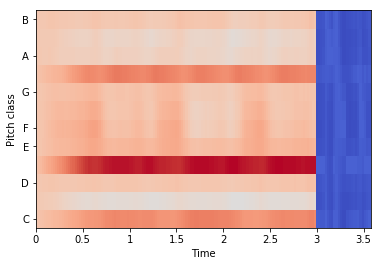

In [15]:
librosa.display.specshow(chromagram2, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
print(chromagram2.shape)